<a href="https://colab.research.google.com/github/Regina00at/2020-01-20191068-JinaKim-Machine-Learning-Programming/blob/master/lesson3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Since I had not enough GPU, I asked Jacinthe that how I can avoid the CUDA out of memory error, and Jacinthe said I can reduce some values such as epoch. So I reduced some values for lesson 3. Thankyou.**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'
#google mount - pre-setting

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#autoreload - pre-setting

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
#import some libraries - pre-setting 여기까지.

In [4]:
path = untar_data(URLs.CAMVID)
#decompress the data file and download it
path.ls()
#listup

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'
#make new path variables for easier use

## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [40]:
fnames = get_image_files(path_img)
#get image from the path/images.
fnames[:3]
#print the first three images

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00990.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06450.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_04530.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
#get image from the path/labels
lbl_names[:3]
#print the first three images

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02040_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01290_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_010020_P.png')]

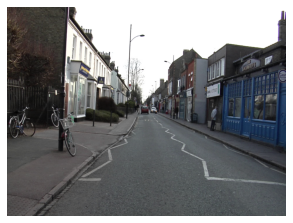

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))
#Show the first image.

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

**[QUESTION]** path_lbl/f'{x.stem}_P{x.suffix}'

what does that mean? I don't get it.

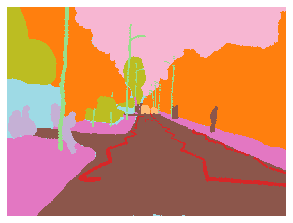

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
#bring a mask and show it

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

**[QUESTION]** Why the shape/type of size is a list?

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes
#print the label

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")
#My GPU have more than 8200MB of memory, so use the faster version.

using bs=8, have 16270MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
#split the data by '/valid.txt'

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
#transform it and normalize it.

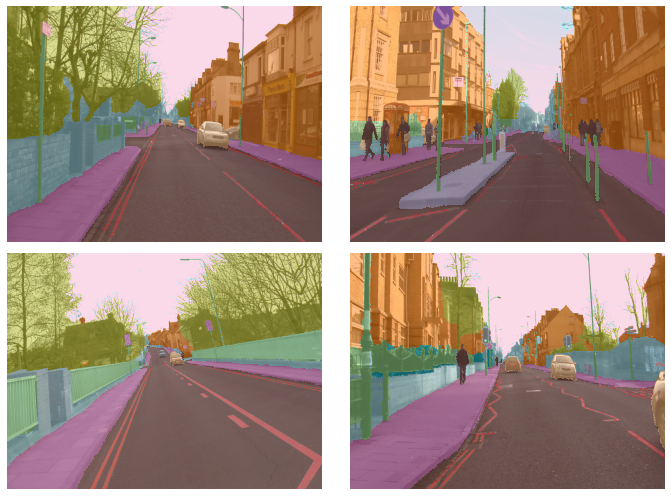

In [16]:
data.show_batch(2, figsize=(10,7))
#show the data 

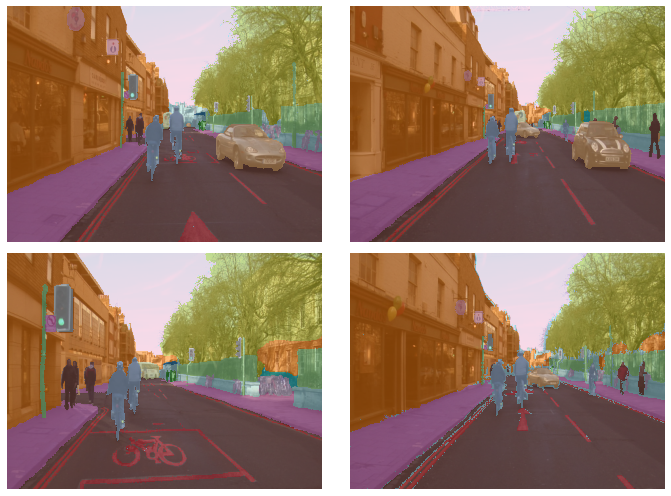

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)
#show the data

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
#Since the metrics never changes the thing related to the model training, acc_camvid is just for the printing and checking.
#download the model resnet 34.

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


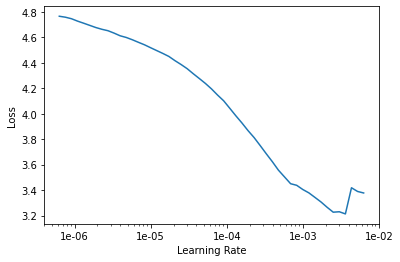

In [22]:
lr_find(learn)
learn.recorder.plot()
#let's find the fastest model and check it as a graph

In [0]:
lr=3e-3
#learning rate = 3e-3

In [24]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.9)
#reduce the number of epoch since my gpu have not enough memory
#train the model for 3 times

epoch,train_loss,valid_loss,acc_camvid,time
0,1.307728,0.991009,0.761057,00:56
1,1.145826,1.327913,0.668330,00:52
2,1.023064,0.720199,0.831738,00:54


In [0]:
learn.save('stage-1')
#save it

In [0]:
learn.load('stage-1');
#load it

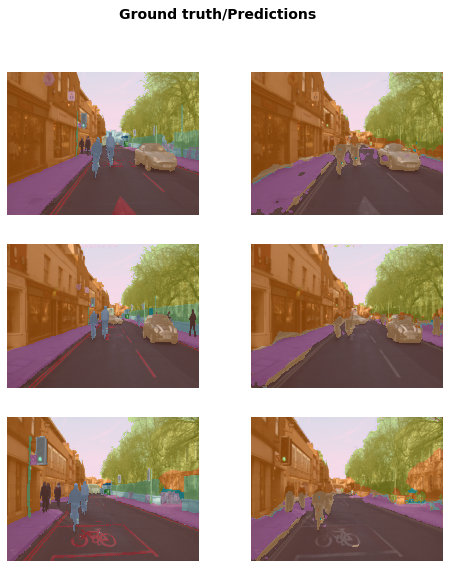

In [27]:
learn.show_results(rows=3, figsize=(8,9))
#show results

In [0]:
learn.unfreeze()
#bring the untrained model

In [0]:
lrs = slice(lr/400,lr/4)
#slice the range of the learning rate

In [31]:
learn.fit_one_cycle(3, lrs, pct_start=0.8)
#reduce the number of epoch since my GPU has not enough memory
#train the model for 3 times

epoch,train_loss,valid_loss,acc_camvid,time
0,0.715815,0.603135,0.847898,00:54
1,0.622979,0.499267,0.866290,00:54
2,0.527671,0.405066,0.889591,00:54


In [0]:
learn.save('stage-2');
#save it

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [33]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")
#if I have enough memory left, go faster training.

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 13217MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
#set the data bunch(transforming and normalizing)

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
#get the model

In [0]:
learn.load('stage-2');
#load previous version

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


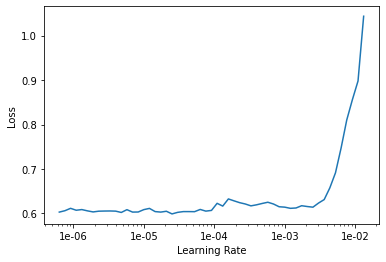

In [37]:
lr_find(learn)
learn.recorder.plot()
#find the fastest model and check it as a graph

In [0]:
lr=1e-3
#learing rate = 1e-3

In [39]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.8)
#train the model for 3times

epoch,train_loss,valid_loss,acc_camvid,time
0,0.535094,0.441133,0.880135,03:36
1,0.512572,0.400314,0.886241,03:33
2,0.446016,0.318812,0.912939,03:33


In [0]:
learn.save('stage-1-big')
#save it

In [0]:
learn.load('stage-1-big');
#load again

In [0]:
learn.unfreeze()
#bring the untrained model

In [0]:
lrs = slice(1e-6,lr/10)
#slice the range of the learning rate

In [45]:
learn.fit_one_cycle(3, lrs)
#train the model

epoch,train_loss,valid_loss,acc_camvid,time
0,0.389388,0.291746,0.920987,03:40
1,0.376455,0.287249,0.921225,03:39
2,0.341697,0.282801,0.922951,03:40


In [0]:
learn.save('stage-2-big')
#save it

In [0]:
learn.load('stage-2-big');
#load it again

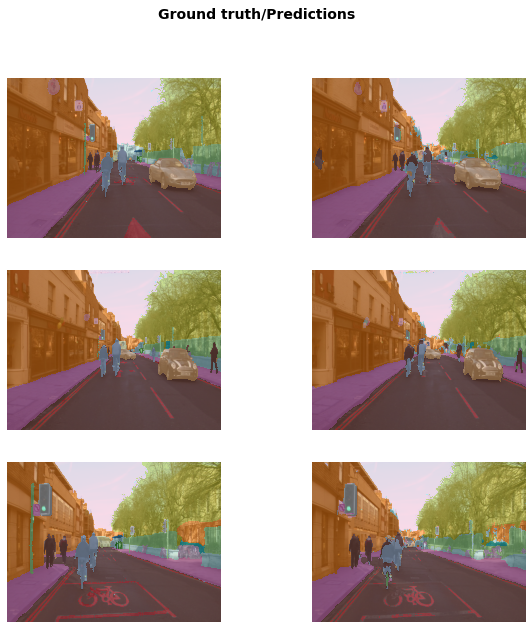

In [48]:
learn.show_results(rows=3, figsize=(10,10))
#show some results

## fin